# Overview

*Adaptie SIS Model Simulation*

The notebook implements an adaptive SIS (Susceptible-Infected-Susceptible) model on a complex network. The network structure evolves over time, where susceptible nodes only reconnect to susceptible nodes they previously met. The code simulates disease transmission, recovery, and network evolution.

**Key Features:**
- Dynamic reconnections based on disease status.
- Monte Carlo simulation for epidemic modeling.
- Visualizations of epidemic statistics (characteristic lifetime, metastable prevalence of infected).





# How to use

Set the parameters you want in "Parameter section". Also set the parameters at the beggining of the MAIN you want to use. The main will run the simulation. The main figures are in the following cells.
However, we recommend to run the parallel version of the code.

If you want to save the figures, replace a valid directory in the line directorio = '/gdrive/MyDrive/Proyecto teórica/Código/Gráficas/' in the section Drive Folder Connection. Then set save=True in their arguments.

We recommend to run in Google colab enviroment.

#Libraries
Prerequisities

In [ ]:
import networkx as nx
import numpy as np
from scipy import stats
from scipy.stats import linregress
import matplotlib.pyplot as plt

## Drive Folder Connection
Lines of code that connect to Google Drive to save the results in the folder called directory.

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
# Please put a valid directory

directorio = '/gdrive/MyDrive/Proyecto teórica/Código/Gráficas/'

In [ ]:
import datetime
NOW = datetime.datetime.now()
MINUTE = NOW.minute
HOUR = NOW.hour
DAY = NOW.day

# Graph Initialization

initialize_graph( N,k,p_ws,infect_percent,seed_G)

In [ ]:
'''
  Al llamarse se inicializa el grafo de Watts Strogatz, así como otros
elementos importantes para el programa
  G_base := grafo inicial, no cambia durante el programa
  G := el grafo principal
  status := Estados de los nodos
  new_status := auxiliar de status
  pos = guarda las posiciones de los nodos en el plotting

'''
def initialize_graph( N,k,p_ws,infect_percent,seed_G):
  global pos
  # Inicializar un grafo y una copia con networkx
  G = nx.watts_strogatz_graph(N, k, p_ws, seed=seed_G)
  G_base = G.copy()
  # Estado inicial de los nodos: 0 = susceptible, 1 = infectado
  status = np.zeros(N)
  initial_infected = np.random.choice(N, size=int(N*infect_percent),
                                      replace=False)
  #print(np.sort(initial_infected))
  status[initial_infected] = 1

  # Initialize positions
  pos = nx.spring_layout(G, seed=1)
  return G, G_base, status

# Video and Draw

Draw the graphs and makes a video for one run of the evolution of the system.

If you want to make a video, remember to put the initialize and finish functions at the beginning and at the end. And draw for each step.

draw( G, status, step)

....

In [ ]:
''' Las variables propias de la creación del video las dejaré globales
'''

import cv2

def initialize_video():
  '''Se inicializan los parámetros globales del video, como el nombre, el tamaño'''
  global out, video_name, frame_size
  # Parameters for the video
  video_name = 'graph_evolution.mp4'
  frame_size = (800, 600)  # Width, Height
  # Initialize VideoWriter object
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  out = cv2.VideoWriter(video_name, fourcc, fps, frame_size)

def draw_on_video(G, status, step):
  # Create a Matplotlib figure
  fig, ax = plt.subplots()
  # Colorear los nodos según su estado inicial
  node_colors = ['red' if status[node] == 1 else 'green' for node in G.nodes]
  # Dibujar el grafo con los nodos coloreados
  nx.draw(G, ax=ax, pos=pos, node_color=node_colors,with_labels=True)
  # Add title to the figure
  plt.title(f"a-SIS Evolution: step = {step+1}")
  # Convert Matplotlib figure to a numpy array
  fig.canvas.draw()
  img = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  img = img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
  # Convert RGB to BGR
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  # Resize the frame to match the frame size
  img = cv2.resize(img, frame_size)
  # Add the frame to the video
  out.write(img)
  # Close the Matplotlib figure
  plt.close(fig)

def finish_video():
  # Release the VideoWriter object
  out.release()
  # Closes all the frames
  cv2.destroyAllWindows()


In [ ]:
'''
   Dibuja el grafo en un tiempo t
'''
def draw( G, status, step):
  # Colorear los nodos según su estado inicial
  node_colors = ['red' if status[node] == 1 else 'green' for node in G.nodes]
  # Dibujar el grafo con los nodos coloreados
  nx.draw(G, pos=pos, node_color=node_colors, with_labels=True)
  # Add title to the figure
  plt.title(f"Graph Evolution: step = {step+1}")
  plt.show()

# Evolution Step Function

The evolution_step0 function simulates one time step of the disease dynamics in the adaptive SIS model. It updates the disease status of nodes and the network connections based on infection, recovery, and reconnection rules.

`evolution_step(G, G_base, status,random_array)`

In [ ]:
def evolution_step(G, G_base, status,random_array):
      """
    Perform one step of the SIS evolution in an adaptive network.
    Parameters:
    - G (networkx.Graph): Current network structure.
    - G_base (networkx.Graph): Original base network structure.
    - status (numpy.array): Array of node statuses (0 for susceptible, 1 for infected).
    Returns:
    - Updated graph and status.
    """
    global rand_idx
    new_status = status.copy()
    nodes = list(G.nodes)
    for i in nodes:
        ## Recovery with numpy where (soon)

        if status[i] == 1:  # Infected
            # Recovery
            if random_array[rand_idx] < p_recov:
                new_status[i] = 0
            rand_idx+=1

            neighbors = list(G.neighbors(i))
            # Disease transmission
            for neighbor in neighbors:
                if status[neighbor] == 0:
                    if random_array[rand_idx] < p_inf:
                        new_status[neighbor] = 1
                    rand_idx+=1
                    if random_array[rand_idx] < p_break:
                        G.remove_edge(i, neighbor)
                    rand_idx+=1

        else:  # Susceptible
            # Link creation (S-S links only)
            potential_neighbors = set(G_base.neighbors(i)) - set(G.neighbors(i))
            for neighbor in potential_neighbors:
                if status[neighbor] == 0 and random_array[rand_idx] < p_create:
                    G.add_edge(i, neighbor)
                rand_idx+=1

    return G, new_status

# Infected vs time


save_infected(infected_in_time, status, step)

average_infected_in_steps(infected_in_time, av_steps)

plot_infected(infected_in_time, averaging_steps = 1, seeds = 1)

In [ ]:
## BORRAR abajo
'''
def initialize_plot():
  global infected_in_time, num_edges, steps
  infected_in_time = np.zeros(steps)
  num_edges = np.zeros(steps)
'''

def save_infected(infected_in_time, status, step):
  #global status, infected_in_time, num_edges
  infected_in_time[step] = np.sum(status)/N
  #num_edges[step] = G.number_of_edges()/(N*k/2) #(N*k/2) is the initial num of edges

def average_infected_in_steps(infected_in_time, av_steps):
    steps = len(infected_in_time)
    inf_aux = np.zeros(steps-av_steps+1)

    for step in range(steps-av_steps+1):
        inf_aux[step] = np.sum(infected_in_time[step:step+av_steps])
    inf_aux = inf_aux / av_steps

    return inf_aux

def plot_infected(infected_in_time, averaging_steps = 1, seeds = 1):
  if averaging_steps > 1:
    infected_in_time = average_infected_in_steps(infected_in_time, averaging_steps)

  size_x = len(infected_in_time)
  X = np.arange(size_x)

  # Create figure and axis objects
  fig1, ax1 = plt.subplots()

  # Plot the first line
  color='tab:red'
  ax1.set_xlabel('Step')
  ax1.set_ylabel('Fraction of infected', color=color)
  ax1.plot(X, infected_in_time, color=color, label='Infected [I]')
  ax1.tick_params(axis='y', labelcolor=color)
  #plt.title(f'N = {N}, k = {k}, tau = {p_inf/p_recov}, omega = {p_create/p_break},\n averaged over {seeds} seeds and {averaging_steps} steps')
  plt.title(f'N = {N}, k = {k}, tau = {(p_inf/p_recov):.2f}, omega = {(p_create/p_break):.2f}' +
          (f'\n averaged over {seeds} seeds' if seeds > 1 else '') +
          (f'\n averaged over {averaging_steps} steps' if averaging_steps > 1 else ''))

  plt.show()



# Parameters
Model and network parameters

In [ ]:
### MODEL PARAMETERS

p_inf = 0.2 #Infection probability (S->I).
p_recov = 0.2 #Recovery probability (I->S).
p_break = 0.5 #Probability of breaking a SI link.
p_create = 0.2 #Probability of creating a SS link.

### NETWORK PARAMETERS

N = 20     #Nunmber of nodes in the network
k = 4      #Average degree
p_ws = 0.2  #p: watts-strogatz parameters

infect_percent = 0.5 #Percentage of initial infected

### PLOT IN TIME

### VIDEO
fps = 2  # Frames per second

# About Prevalence

Functions to calculate the prevalence of infected nodes and plot


```
find_prevalence(infected_just_endemic, n_endemic_states, seeds, min_fraction=0.7, plot=False, save=False)

prevalence_vs_tau(prevalence, tau, std = None, omega=p_break/p_create)
```



In [ ]:
#Infected prevalence

def find_prevalence(infected_just_endemic, n_endemic_states, seeds, min_fraction=0.3, m_loc_min=3, omega=-1, tau = -1, plot=False, save=False):
  '''Returns the mean of infected and standar deviation of infected
  where there is still more than 0.7 states in infected season'''
  #step_of_healty = np.argmax(infected_in_time == 0)
  # First a pre- prevalence
  infected_to_analyse = infected_just_endemic[n_endemic_states>min_fraction]
  mean_infected = np.mean(infected_to_analyse)
  std_dev_infected = np.std(infected_to_analyse)

  # This section avoid to analyse the non-metaestable part at the beginning
  first_idx = np.where(infected_to_analyse<mean_infected)[0][0]
  preva_infected_to_analyse = infected_to_analyse[first_idx:]



  # This section try to solve some issues with small taus, finding a lm_idx local minima,
  # and ignoring infected before this one
  local_minima_indices = (np.diff(np.sign(np.diff(preva_infected_to_analyse))) > 0).nonzero()[0] + 1

  if len(local_minima_indices) > m_loc_min:
    lm_idx = local_minima_indices[m_loc_min]
  else:
    for i in range(10):
      min_fraction = 0.5*min_fraction
      infected_to_analyse = infected_just_endemic[n_endemic_states>min_fraction]
      preva_infected_to_analyse = infected_to_analyse[first_idx:]
      local_minima_indices = (np.diff(np.sign(np.diff(preva_infected_to_analyse))) > 0).nonzero()[0] + 1
      if len(local_minima_indices) > m_loc_min:
        lm_idx = local_minima_indices[m_loc_min]
        break
      else:
        lm_idx = len(preva_infected_to_analyse)-3
  mean_infected = np.mean(preva_infected_to_analyse[lm_idx:])
  std_dev_infected = np.std(preva_infected_to_analyse[first_idx:])


  # Figure
  if plot or save:
    size_x = len(infected_to_analyse)
    X = np.arange(size_x)
    plt.plot(X, infected_to_analyse, label=f'Infected Mean over {seeds} seeds', color='tab:blue', zorder=1)
    vec_prevalence = np.full( size_x, mean_infected)
    plt.plot(X, vec_prevalence, color='red', label='Prevalence', linestyle='--', zorder=3)
    vec_std = np.full(size_x, std_dev_infected)
    plt.fill_between(X, vec_prevalence - vec_std, vec_prevalence + vec_std, color='red', alpha=0.2, label='Standard Deviation', zorder=2)
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Fraction of infected')
    plt.title(f'Prevalence for ' + r'$\tau$ = '+ f'{tau:.2f} and '+ r'$\omega$ = '+f'{omega:.2f} \n N = {N}, k = {k}, seeds = {seeds}')
    plt.grid(True)
    if save: plt.savefig(directorio + f'Prevalence tau = {tau:.2f} omega = {omega:.2f} seeds = {seeds} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    if plot:
      plt.show()
  return mean_infected, std_dev_infected


def prevalence_vs_tau(prevalence, tau, std = None, omega=p_break/p_create, seeds = None, steps=None, save= False):
  plt.plot(tau, prevalence, marker='o', linestyle='-', label='Prevalence', color='tab:red')
  if isinstance(std, np.ndarray):
    plt.fill_between(tau, prevalence - std, prevalence + std, alpha=0.2,label='Standard Deviation', color='tab:red')
  plt.legend()
  plt.xlabel(r'Effective infection rate $\tau$')
  plt.ylabel('Prevalence of infected')
  plt.title(r'Prevalence vs $\tau$'+ '\n ' + f'N = {N}, k = {k},' +r' $\omega$ = '+f'{omega:.2f}' +(f',\n seeds = {seeds}' if seeds else '')+(f', steps = {steps}' if steps else ''))
  if save: plt.savefig(directorio + f'Prevalence vs Tau omega = {omega:.2f} N = {N} k = {k} seeds = {seeds} fecha-{DAY}-{HOUR}:{MINUTE}.png')
  plt.show()

#Plot prevalence vs Tau per omega
def plot_prevalence_vs_tau(taus, prevalence_per_omega, std_prevalence_per_omega, seeds=None, save=False):
   # Normal plot
    #plt.figure(figsize=(10, 6))
    for omega in prevalence_per_omega.keys():
        plt.errorbar(taus, prevalence_per_omega[omega], yerr=std_prevalence_per_omega[omega],
                     label=r' $\omega$ = ' + f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o',markerfacecolor='none')
    # Axis labels with LaTeX formatting
    plt.xlabel(r'Effective infection rate $\tau$', fontsize=10.5)
    plt.ylabel('Prevalence of Infected', fontsize=10.5)

    # Title with network parameters

    plt.title(r'$\bf{Prevalence\ of\ Infected\ vs.\ }\tau$' + '\n' +
          f'N = {N}, k = {k}' + (f', seeds = {seeds}' if seeds else '') +
        (f', steps = {steps}' if steps else ''), fontsize=13)
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Prevalence vs Tau per Omega k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()

    # Semilog plot
    #plt.figure(figsize=(10, 6))
    for omega in prevalence_per_omega.keys():
        plt.errorbar(taus, prevalence_per_omega[omega], yerr=std_prevalence_per_omega[omega],
                     label=r' $\omega$ = ' + f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o',markerfacecolor='none')
    # Axis labels with LaTeX formatting
    plt.xlabel(r'Effective infection rate $\tau$', fontsize=10.5)
    plt.ylabel('Prevalence of Infected', fontsize=10.5)

    # Title with network parameters
    plt.title(r'$\bf{Prevalence\ of\ Infected\ vs.\ }\tau$' + '\n' +
          f'N = {N}, k = {k}' + (f', seeds = {seeds}' if seeds else '') +
        (f', steps = {steps}' if steps else ''), fontsize=13)

    # Set y-axis to logarithmic scale
    plt.yscale('log')

    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Prevalence vs Tau per Omega Semilog k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()




# About Life time

Functions to calculate the Characteristic Lifetime and plot related figures

```
step_healty(infected_in_time)

endemic_vs_time(life_time, steps, n_seeds, plot=False)

calculate_average_lifetime(n_endemic_states, start=None, end=None, plot=True, save=False)
```




In [ ]:
def step_healty(infected_in_time):
  '''Returns the first step of healty state. Returns steps+1 if still endemic '''
  step_of_healty = np.argmax(infected_in_time == 0)
  if step_of_healty==0 and infected_in_time[-1]>0: #just in case the endemic state continues
    step_of_healty = len(infected_in_time) + 1
  return step_of_healty
''' infected_in_time==0 is a boolean array, argmax takes the first index when this
array is a maximum, in this case, when infected_in_time==0 takes the value 1 '''


def endemic_vs_time(life_time, steps, seeds, plot=False,save=False, tau = p_inf/p_recov, omega = p_break/p_create):
  fraction_of_endemic = np.zeros(steps)
  for step in range(steps):
    #print(np.sum(life_time > step))
    fraction_of_endemic[step] = np.sum(life_time > step)/n_seeds
  if plot or save:
    plt.plot(np.arange(steps),fraction_of_endemic)
    #plt.title(f'Endemic states lifetime = {average_lifetime:.2f} steps\n'+
    #   (f'tau = {tau:.2f}' if tau else '')+(f', omega = {omega:.2f}' if omega else '')+
    #    f', N = {N}, k = {k}'+(f', seeds = {seeds}' if seeds else ''))
    plt.title(f'Endemic fraction vs time \n'+
       (f'tau = {tau:.2f}' if tau else '')+(f', omega = {omega:.2f}' if omega else '')+
        f', N = {N}, k = {k}'+(f', seeds = {seeds}' if seeds else ''))
    plt.xlabel('Steps')
    plt.ylabel('Fraction of Endemic States')
    plt.legend()
    if save: plt.savefig(directorio + f'endemic fraction vs time'+(f' tau = {tau:.2f}' if tau else '')+
     (f' omega = {omega:.2f}' if omega else '')+(f' seeds = {seeds}' if seeds else '')+f' fecha-{DAY}-{HOUR}:{MINUTE}.png')
    if plot:
      plt.show()
  return fraction_of_endemic

def calculate_average_lifetime(n_endemic_states, start=None, end=None, plot=False, save=False, tau = -1, omega = -1, seeds = None ):
    """
    Calculate the average lifetime of a disease from the semilog graph.

    Parameters:
    - endemic_states: Array of the fraction of endemic states over time
    - start: Start index of the linear region for the fit (default is 0)
    - end: End index of the linear region for the fit (default is step)

    Returns:
    - average_lifetime: The calculated average lifetime of the disease
    """
    if start is None:
        start = 0  # Default start is the first index
    if end is None:
        end = len(n_endemic_states)  # Default end is the last index
    # Fit a line to the log of the endemic states in the exponential decay region
    XX = np.arange(start, end)
    endemic_states_section = n_endemic_states[start:end]
    valid_indices = endemic_states_section > 0  # Identify positive values
    XX = XX[valid_indices]
    #print(XX)
    log_endemic_states = np.log(endemic_states_section[valid_indices])
    #log_endemic_states = np.log(endemic_states[start:end])


    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(XX, log_endemic_states)

    # Calculate the average lifetime
    average_lifetime = -1 / slope

    # Plotting with the linear fit
    if plot or save:
      plt.plot(np.arange(len(n_endemic_states)), n_endemic_states, label='Data')
      plt.plot(XX, np.exp(slope * XX + intercept), label='Linear Fit', linestyle='--')
      plt.yscale('log')
      plt.xlim(0, 60)
      plt.ylim(0, 2)
      plt.title(f'Endemic states with lifetime = {average_lifetime:.2f} steps\n'+
       (r'$\tau$ = '+f'{tau}' if tau else '')+(r', $\omega$ = '+f'{omega}' if omega else '')+
        f', N = {N}, k = {k}'+(f', seeds = {seeds}' if seeds else ''))
      plt.xlabel('Steps')
      plt.ylabel('Fraction of Endemic States')
      plt.legend()
      plt.grid(True)
      if save: plt.savefig(directorio + f's-log_endemic_'+(f'_tau:{int(tau*10)}' if tau else '')+
       (f'_ome:{omega}' if omega else '')+(f'_seeds:{seeds}' if seeds else '')+f'__fecha-{DAY}-{HOUR}:{MINUTE}.png')
      if plot:
        plt.show()
        #print(f"Average Lifetime of Disease: {average_lifetime:.2f} time steps")

    return average_lifetime

def mean_life_time_vs_time(taus, average_lifetimes, seeds=None, omega = p_break/p_create):
  plt.plot(taus, average_lifetimes, marker = 'o', linestyle='-', label='Characteristic Lifetime', color='tab:blue')
  plt.xlabel(r'Effective infection rate $\tau$')
  plt.ylabel('Characteristic Lifetime (Steps)')
  plt.title('Characteristic Lifetime vs. '+ r'$\tau$'+ '\n'+ f'N = {N}, k = {k},'+ r' $\omega$ = '+f'{omega:.2f}'+(f', seeds = {seeds}' if seeds else ''))
  plt.yscale('log')
  plt.show()

  plt.plot(taus, average_lifetimes, marker = 'o', linestyle='-', label='Average Lifetime', color='tab:blue')
  plt.xlabel(r'Effective infection rate $\tau$')
  plt.ylabel('Characteristic Lifetime (Steps)')
  plt.title('Characteristic Lifetime vs. '+ r'$\tau$'+ '\n'+ f'N = {N}, k = {k},'+ r' $\omega$ = '+f'{omega:.2f}'+(f', seeds = {seeds}' if seeds else ''))
  plt.show()

#Plot average lifetime vs tau per omega
def plot_average_lifetime_vs_tau(tau_values, average_lifetime_per_omega, seeds=None, save=False):
    """
    Function to plot average_lifetime vs. tau for different omega values.

    Parameters:
    - tau_values: List of tau values.
    - avg_lifetime_per_omega: Dictionary of lists of average lifetimes per omega.
    """
    #plt.figure(figsize=(10, 6))

    # Plotting each line for different omega values
    for omega, average_lifetime in average_lifetime_per_omega.items():
        inf_indx = len(tau_values)
        if np.isinf(average_lifetime[-1]):
          inf_indx = np.where(np.isinf(average_lifetime))[0][0]
        plt.plot(tau_values[:inf_indx], average_lifetime[:inf_indx], label=r' $\omega$ = '+f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o', markerfacecolor='none')
        #plt.plot(tau_values, average_lifetime, label=r' $\omega$ = '+f'{omega:.2f}', marker='o', markerfacecolor='none')
    #Normal plot
    plt.xlabel(r'Effective infection rate $\tau$', fontsize=10.5)
    plt.ylabel('Characteristic Lifetime (Steps)', fontsize=10.5)
    #Title
    plt.title(r'$\bf{Characteristic\ Lifetime\ vs.\ } \tau$' + '\n' +
              f'N = {N}, k = {k}' + (f', seeds = {n_seeds}' if seeds else '') +(f', steps = {steps}'))
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Characteristic Lifetime vs Tau k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()
    for omega, average_lifetime in average_lifetime_per_omega.items():
        inf_indx = len(tau_values)
        if np.isinf(average_lifetime[-1]):
          inf_indx = np.where(np.isinf(average_lifetime))[0][0]
        plt.plot(tau_values[:inf_indx], average_lifetime[:inf_indx], label=r' $\omega$ = '+f'{omega:.2f}'+(' (SIS)' if omega==0 else ''), marker='o', markerfacecolor='none')
    #Semilog plot
    plt.xlabel(r'Effective infection rate $\tau$', fontsize = 10.5)
    plt.ylabel('Characteristic Lifetime (Steps)', fontsize = 10.5)
    #Title
    plt.title(r'$\bf{Characteristic\ Lifetime\ vs.\ } \tau$' + '\n' + f'N = {N}, k = {k}' + (f', seeds = {n_seeds}' if seeds else '') +(f', steps = {steps}'))
    plt.yscale('log')
    plt.legend()
    plt.grid(True)
    if save: plt.savefig(directorio + f'Characteristic Lifetime vs Tau Semilog k = {k} seeds = {n_seeds} p_r = {p_recov} p_c = {p_create} fecha-{DAY}-{HOUR}:{MINUTE}.png')
    plt.show()


# MAIN: Average over seeds with Taus

This is the Monte Carlo sampling for some taus and omega values.

Set the best parameters you want for tau and omega values, number of seeds, and of steps.


In [ ]:
## Parameters for this cell

# More values between 0 and 1
#taus_fine = np.linspace(0, 1, 8)
# Fewer values between 1 and 5
#taus_coarse = np.linspace(1, 5, 8)
# Combine both arrays, excluding the duplicate 1 from taus_coarse
#taus = np.concatenate((taus_fine, taus_coarse[1:]))
taus = np.linspace(0, 5, 10)  # tau_max = 1/p_recov
average_lifetimes = []
omega_values = [0, 0.5, 1, 2]
n_seeds = 500
steps = 2000

# Storage for results
average_lifetime_per_omega = {omega: [] for omega in omega_values}
prevalence_per_omega = {omega: [] for omega in omega_values}
std_prevalence_per_omega = {omega: [] for omega in omega_values}


#Monte Carlo Simulation
for omega in omega_values:
  p_break = omega * p_create #Adjust p_break based on omega, p_create constant
  average_lifetime_vs_tau = []
  prevalence_vs_tau = []
  std_prevalence_vs_tau = []
  for tau in taus:
    p_inf = tau * p_recov #Adjust p_inf based on tau, p_recov is constant
    #### Initialize the arrays for measurements
    sum_infected_in_time = np.zeros(steps) # To sum infected_in_time of each seed
    life_time = np.zeros(n_seeds) # The life time of each seed

    #sum_infected_just_endemic = np.zeros(steps)

    ###### MONTE CARLO SAMPLING
    for seed in range(n_seeds):
      ######## Initializing grap
      seed_G = 0
      G, G_base, status = initialize_graph(N,k,p_ws,infect_percent,seed_G)

      ## Epidemic SImulation
      infected_in_time = np.zeros(steps)

      ## Random array
      np.random.seed(seed)
      dim_ra = steps*N*(k+1)
      random_array = np.random.rand(dim_ra)
      rand_idx = 0  #global index for random array

      ######## EVOLUTION of the network
      step =-1
      #draw(G, status, step)
      for step in range(steps):
        G, status = evolution_step(G, G_base, status, random_array)
        #G, status = evolution_step0(G, G_base, status)
        save_infected(infected_in_time, status, step)
        if infected_in_time[step]==0:
          break
        #if step< 15: draw( G, status, step)
        #draw(G, status, step)
      #draw( G, status, step)
      ######### Measurements
      sum_infected_in_time += infected_in_time
      life_time[seed] = step_healty(infected_in_time)

      #plot_infected(infected_in_time)

    #Calculate endemic states and average lifetime
    n_endemic_states = endemic_vs_time(life_time, steps, n_seeds, plot=False, save=False, tau = tau, omega = omega)
    #print(n_endemic_states)
    average_lifetime = calculate_average_lifetime(n_endemic_states,plot=False)
    average_lifetime_vs_tau.append(average_lifetime)

    #Calculate infected just endemic phase
    mean_infected_in_time = sum_infected_in_time/n_seeds
    infected_just_endemic = np.where(n_endemic_states>0, mean_infected_in_time/n_endemic_states,0)

    # Calculate prevalence and standard deviation
    mean_infected, std_dev_infected = find_prevalence(infected_just_endemic, n_endemic_states, n_seeds, plot=False)
    prevalence_vs_tau.append(mean_infected)
    std_prevalence_vs_tau.append(std_dev_infected)

  # Store the results for this omega
  average_lifetime_per_omega[omega] = average_lifetime_vs_tau
  prevalence_per_omega[omega] = prevalence_vs_tau
  std_prevalence_per_omega[omega] = std_prevalence_vs_tau

<ipython-input-17-6711a1d23429>:74: RuntimeWarning: invalid value encountered in divide
  infected_just_endemic = np.where(n_endemic_states>0, mean_infected_in_time/n_endemic_states,0)
<ipython-input-16-bd661f09aeaa>:63: RuntimeWarning: divide by zero encountered in scalar divide
  average_lifetime = -1 / slope


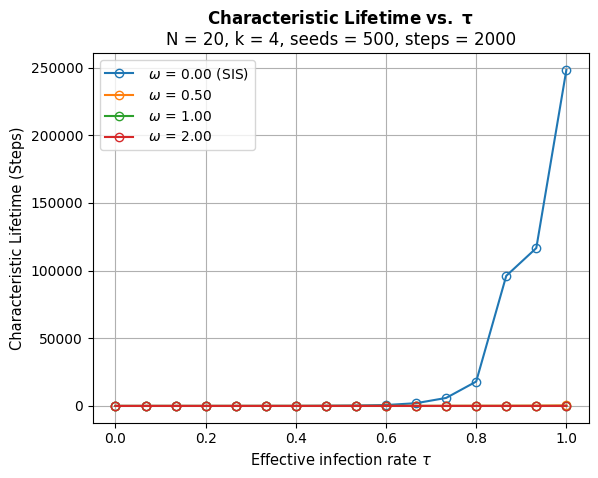

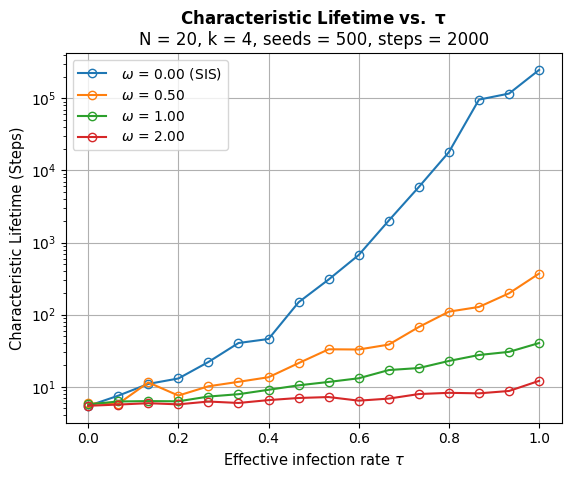

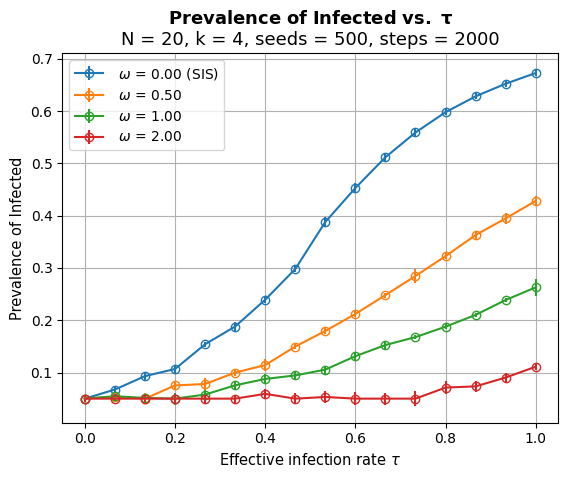

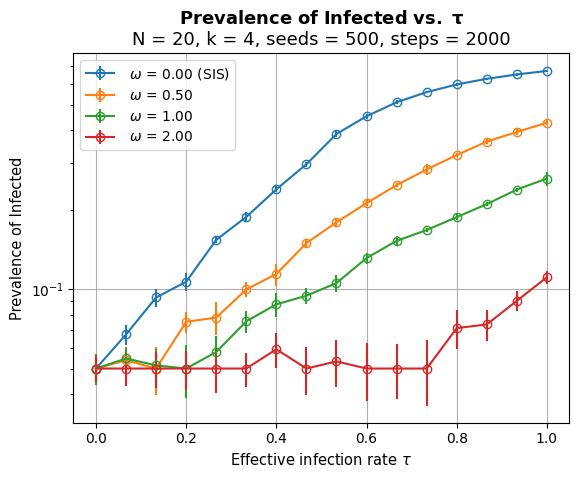

In [ ]:
#Plot results
plot_average_lifetime_vs_tau(taus, average_lifetime_per_omega,n_seeds)#,save=True)
plot_prevalence_vs_tau(taus,prevalence_per_omega,std_prevalence_per_omega, n_seeds)#,save=True)

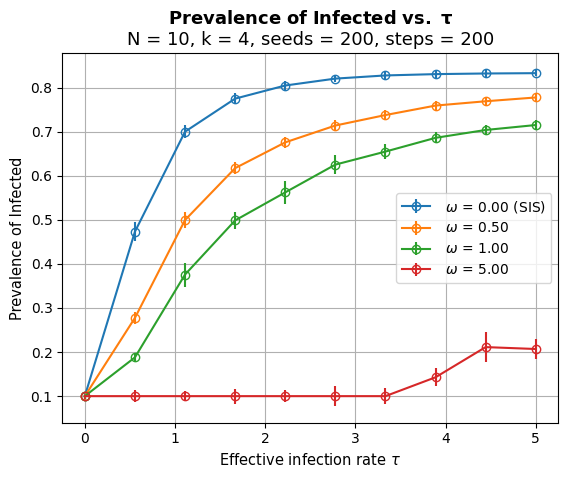

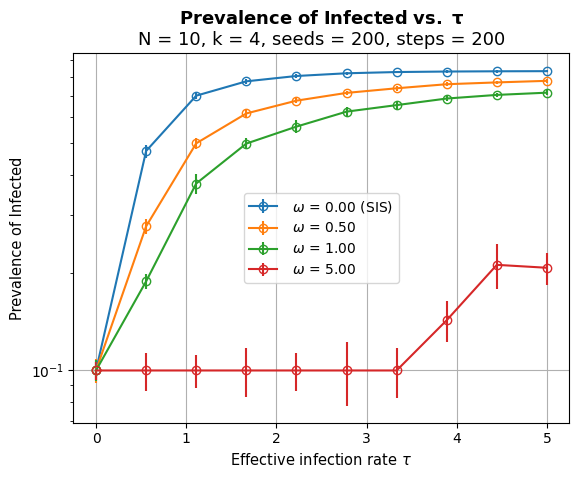

In [ ]:
## Plot the figure prevalence vs tau for some omega values.

plot_prevalence_vs_tau(taus,prevalence_per_omega,std_prevalence_per_omega, n_seeds)

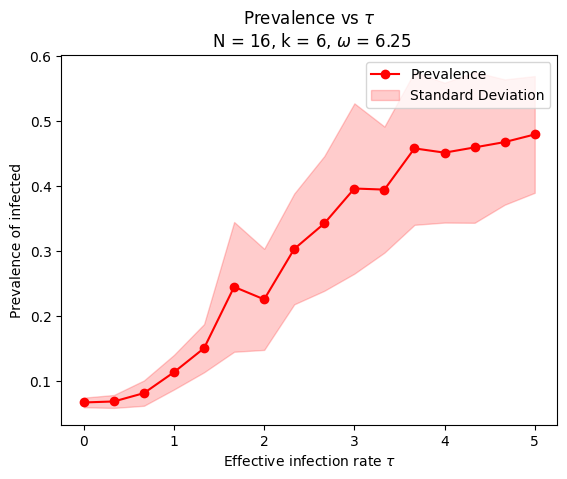

In [ ]:
# For a single omega
#prevalence_vs_tau(prevalence, taus, std = std_prevalence)
#find_prevalence(infected_just_endemic, n_endemic_states, n_seeds, plot=True)

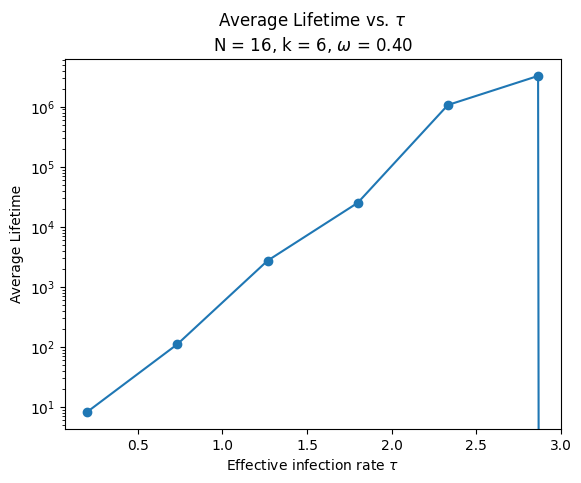

<ipython-input-126-7e8a93a3bcd8>:63: RuntimeWarning: divide by zero encountered in scalar divide
  average_lifetime = -1 / slope


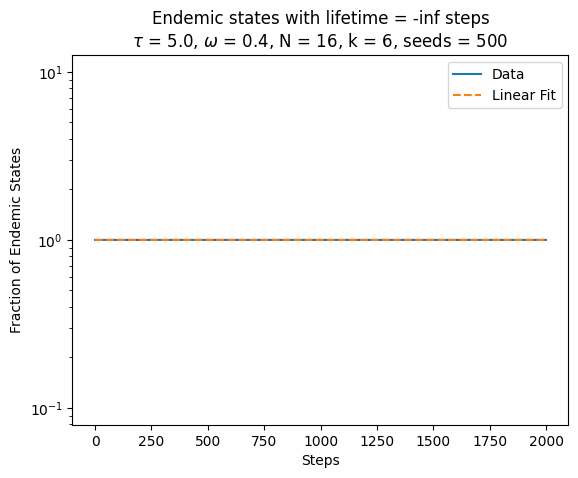

-inf

In [ ]:
#Characteristic lifetime vs taus for one run
#mean_life_time_vs_time(taus, average_lifetimes)
#calculate_average_lifetime(n_endemic_states, plot=True, seeds = n_seeds )

# MAIN2:
## One onset of parameters: 1 omega, 1 tau

In [ ]:
n_seeds = 500
steps = 2000
tau = 0.1
omega = 1.0

#### Initialize the arrays for measurements
sum_infected_in_time = np.zeros(steps) # To sum infected_in_time of each seed
life_time = np.zeros(n_seeds) # The life time of each seed
for seed in range(n_seeds):
      ######## Initializing grap
      seed_G = 0
      G, G_base, status = initialize_graph(N,k,p_ws,infect_percent,seed_G)

      ## Epidemic SImulation
      infected_in_time = np.zeros(steps)

      ## Random array
      np.random.seed(seed)
      dim_ra = steps*N*(k+1)
      random_array = np.random.rand(dim_ra)
      rand_idx = 0  #global index for random array

      ######## EVOLUTION of the network
      step =-1
      #draw(G, status, step)
      for step in range(steps):
        G, status = evolution_step(G, G_base, status, random_array)
        #G, status = evolution_step0(G, G_base, status)
        save_infected(infected_in_time, status, step)
        if infected_in_time[step]==0:
          break
        #if step< 15: draw( G, status, step)
        #draw(G, status, step)
      #draw( G, status, step)
      ######### Measurements
      sum_infected_in_time += infected_in_time
      life_time[seed] = step_healty(infected_in_time)

mean_infected_in_time = sum_infected_in_time/n_seeds
n_endemic_states = endemic_vs_time(life_time, steps, n_seeds, plot=False, save=False, tau = tau, omega = omega)
infected_just_endemic = np.where(n_endemic_states>0, mean_infected_in_time/n_endemic_states,0)


<ipython-input-80-c7abb78056b7>:41: RuntimeWarning: invalid value encountered in divide
  infected_just_endemic = np.where(n_endemic_states>0, mean_infected_in_time/n_endemic_states,0)


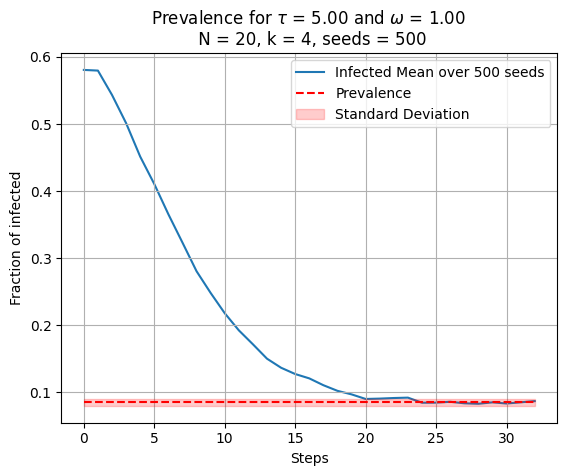

(0.0847956141579463, 0.0053822841726531324)

In [ ]:
find_prevalence(infected_just_endemic, n_endemic_states, n_seeds, plot=True, save=False)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50]


<ipython-input-71-cf66c5c81f17>:71: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 2)


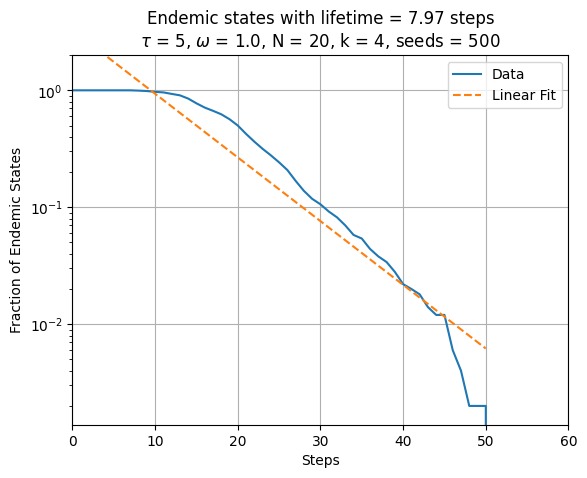

7.97326030607311

In [ ]:
calculate_average_lifetime(n_endemic_states, plot=True, save=False, seeds = n_seeds)